In [1]:
import numpy as np
#%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Load the dataset

In [8]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# Inspect the dataset

In [9]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


<Figure size 432x288 with 0 Axes>

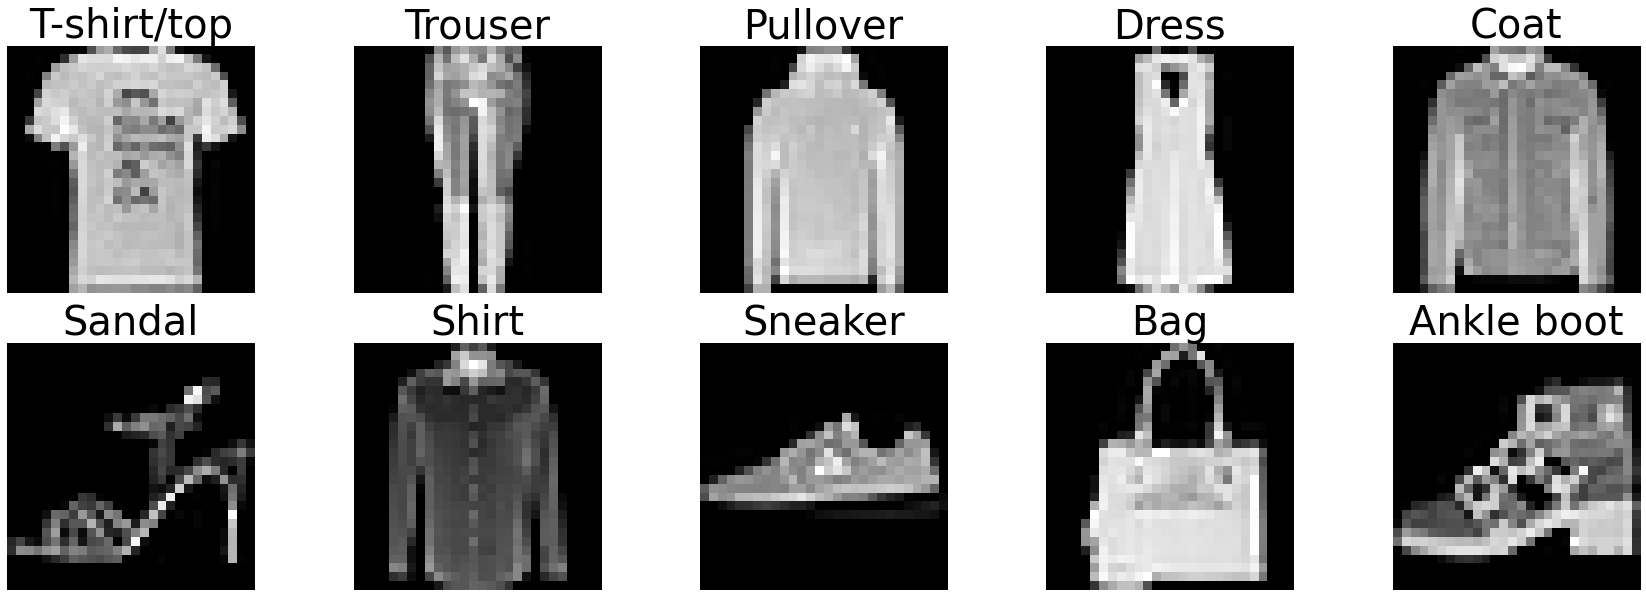

In [10]:
explicit_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.gray()
fig, ax = plt.subplots(2,5,figsize=(30,10))
for label in range(10):
    idx = np.random.choice(np.where(test_labels==label)[0])
    ax[label//5,label%5].imshow(test_images[idx])
    ax[label//5,label%5].set_title(explicit_labels[test_labels[idx]], fontsize=40)
    ax[label//5,label%5].axis("off")

# Preprocess the data

In [11]:
# Set input shape for model
my_input_shape = (28,28,1)

# Create training and test dataset form the images
train_dataset = tf.data.Dataset.from_tensor_slices(train_images)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images)

# Normalize images
train_dataset = train_dataset.map(lambda img: tf.cast(tf.expand_dims(img/255,-1),tf.float32),
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.map(lambda img: tf.cast(tf.expand_dims(img/255,-1),tf.float32),
                                num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Cache the preprocessed datasets
train_dataset = train_dataset.cache()
test_dataset = test_dataset.cache()

# Shuffle the data
train_dataset = train_dataset.shuffle(64)
test_dataset = test_dataset.shuffle(64)

# Create minibatches
train_dataset = train_dataset.batch(64)
test_dataset = test_dataset.batch(64)

# Prefetch the data
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# Define Encoder

In [12]:
from tensorflow.keras import Model, regularizers

class ConvEncoder(Model):
    def __init__(self, embedding_size = 10):
        super(ConvEncoder, self).__init__()
        self.input_layer = tf.keras.layers.Input(my_input_shape)
        
        self.my_layers = [
            tf.keras.layers.Conv2D(
                filters=64,
                kernel_size=3,
                strides=2,
                padding='same',
                activation='relu'          
            ),
            tf.keras.layers.Conv2D(
                filters=128,
                kernel_size=3,
                strides=2,
                padding='same',
                activation='relu'
            ),
            tf.keras.layers.Flatten(),        
            tf.keras.layers.Dense(
                units=embedding_size,
                activation = None
            )
        ]
        
        self.out = self.call(self.input_layer)
    
    def call(self, x):
        for layer in self.my_layers:
            x = layer(x)
        return x

In [13]:
conv_enc = ConvEncoder()
_ = conv_enc(tf.zeros([1,28,28,1]))
conv_enc.summary()

Model: "conv_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                62730     
Total params: 137,226
Trainable params: 137,226
Non-trainable params: 0
_________________________________________________________________


# Define Decoder

In [14]:
class ConvDecoder(Model):
    def __init__(self, embedding_size = 10):
        super(ConvDecoder, self).__init__()
        self.input_layer = tf.keras.layers.Input(embedding_size)
        
        self.my_layers = [
            tf.keras.layers.Dense(
                units=6272, 
                activation='relu'
            ),
            tf.keras.layers.Reshape(
                target_shape=(7,7,128)
            ),
            tf.keras.layers.Conv2DTranspose(
                filters=64,
                kernel_size=3,
                strides=2,
                padding='same',
                activation='relu'
            ),
            tf.keras.layers.Conv2DTranspose(
                filters=1,
                kernel_size=3,
                strides=2,
                padding='same',
                activation='sigmoid'
            )            
        ]
        
        self.out = self.call(self.input_layer)
        
    def call(self, x):
        for layer in self.my_layers:
            x = layer(x)
        return x        

In [235]:
conv_dec = ConvDecoder()
_ = conv_dec(conv_enc(tf.zeros([1,28,28,1])))
conv_dec.summary()

Model: "conv_decoder_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 6272)              68992     
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 64)        73792     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 1)         577       
Total params: 143,361
Trainable params: 143,361
Non-trainable params: 0
_________________________________________________________________


# Define full Autoencoder

In [3]:
class ConvAutoencoder(Model):
    def __init__(self, embedding_size = 10):
        super(ConvAutoencoder, self).__init__()
        self.input_layer = tf.keras.layers.Input(my_input_shape)
        
        self.encoder = ConvEncoder(embedding_size)
        
        self.decoder = ConvDecoder(embedding_size)
        
        self.out = self.call(self.input_layer)

    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [50]:
conv_enc_dec = ConvAutoencoder()
_ = conv_enc_dec(tf.zeros([1,28,28,1]))
conv_enc_dec.summary()

Model: "conv_autoencoder_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_encoder_2 (ConvEncoder) (None, 10)                137226    
_________________________________________________________________
conv_decoder_3 (ConvDecoder) (None, 28, 28, 1)         143361    
Total params: 280,587
Trainable params: 280,587
Non-trainable params: 0
_________________________________________________________________


# Define variational Encoder

In [31]:
import tensorflow_probability as tfp

class VarEncoder(Model):
    def __init__(self, prior, embedding_size = 10):
        super(VarEncoder, self).__init__()
        self.input_layer = tf.keras.layers.Input(my_input_shape)
        
        self.my_layers = [
            tf.keras.layers.Conv2D(
                filters=64,
                kernel_size=3,
                strides=2,
                padding='same',
                activation='relu'          
            ),
            tf.keras.layers.Conv2D(
                filters=128,
                kernel_size=3,
                strides=2,
                padding='same',
                activation='relu'
            ),
            tf.keras.layers.Flatten(),        
            tf.keras.layers.Dense(
                units=tfp.layers.MultivariateNormalTriL.params_size(embedding_size),
                activation = None
            ),
            tfp.layers.MultivariateNormalTriL(
                event_size=embedding_size,
                activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior, weight=1.0)
            )
        ]
        
        self.out = self.call(self.input_layer)
    
    def call(self, x):
        for layer in self.my_layers:
            x = layer(x)
        return x

In [34]:
prior = tfp.distributions.Independent(tfp.distributions.Normal(loc=tf.zeros(10), scale=1),
                                      reinterpreted_batch_ndims=1)
var_enc = VarEncoder(prior)
_ = var_enc(tf.zeros([1,28,28,1]))
var_enc.summary()

Model: "var_encoder_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 14, 14, 64)        640       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 7, 7, 128)         73856     
_________________________________________________________________
flatten_12 (Flatten)         (None, 6272)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 65)                407745    
_________________________________________________________________
multivariate_normal_tri_l_9  ((None, 10), (None, 10))  0         
Total params: 482,241
Trainable params: 482,241
Non-trainable params: 0
_________________________________________________________________


# Define variational Decoder

In [42]:
class ConvDecoder(Model):
    def __init__(self, embedding_size = 10):
        super(ConvDecoder, self).__init__()
        self.input_layer = tf.keras.layers.Input(embedding_size)
        
        self.my_layers = [
            tf.keras.layers.Dense(
                units=6272, 
                activation='relu'
            ),
            tf.keras.layers.Reshape(
                target_shape=(7,7,128)
            ),
            tf.keras.layers.Conv2DTranspose(
                filters=64,
                kernel_size=3,
                strides=2,
                padding='same',
                activation='relu'
            ),
            tf.keras.layers.Conv2DTranspose(
                filters=1,
                kernel_size=3,
                strides=2,
                padding='same',
                activation='sigmoid'
            )            
        ]
        
        self.out = self.call(self.input_layer)
        
    def call(self, x):
        for layer in self.my_layers:
            x = layer(x)
        return x        

{'distribution': <tfp.distributions.MultivariateNormalTriL 'var_encoder_12_multivariate_normal_tri_l_9_MultivariateNormalTriL_MultivariateNormalTriL' batch_shape=[1] event_shape=[10] dtype=float32>,
 'convert_to_tensor_fn': <function tensorflow_probability.python.distributions.distribution.Distribution.sample(self, sample_shape=(), seed=None, name='sample', **kwargs)>}

In [ ]:
var_dec = VarDecoder()
_ = var_dec(var_enc(tf.zeros([1,28,28,1])))
var_dec.summary()

# Define variational Autoencoder

In [47]:
class VarAutoencoder(Model):
    def __init__(self, prior, embedding_size = 10):
        super(VarAutoencoder, self).__init__()
        self.input_layer = tf.keras.layers.Input(my_input_shape)
        
        self.encoder = VarEncoder(prior, embedding_size)
        
        self.decoder = ConvDecoder(embedding_size)
        
        self.out = self.call(self.input_layer)

    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [54]:
var_enc_dec = VarAutoencoder(prior)
_ = var_enc_dec(tf.zeros([1,28,28,1]))
var_enc_dec.summary()

Model: "var_autoencoder_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
var_encoder_14 (VarEncoder)  (None, 10)                482241    
_________________________________________________________________
conv_decoder_4 (ConvDecoder) (None, 28, 28, 1)         143361    
Total params: 625,602
Trainable params: 625,602
Non-trainable params: 0
_________________________________________________________________


[<tf.Tensor: shape=(), dtype=float32, numpy=2.1476698>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.1476698>]

# Define the training process

#### Function to plot the models performance

In [51]:
from IPython.display import clear_output

def visualize_progress(model, num_epochs, train_losses, test_losses):
    clear_output(wait=True)
    fig = plt.figure(figsize=(5,5))
    plt.subplot(2,1,1)
    plt.xlim((0,num_epochs))
    plt.plot(train_losses,label="Training")
    plt.plot(test_losses,label="Test")
    plt.ylabel("Loss",fontsize=12)
    plt.xlabel("Epochs",fontsize=12)
    plt.xticks(np.arange(0,num_epochs,2))
    plt.legend()

    idx = np.random.choice(test_images.shape[0])
    plt.subplot(2,2,3)
    plt.imshow(test_images[idx])
    plt.title(explicit_labels[test_labels[idx]], fontsize=20)
    plt.axis("off")
    plt.subplot(2,2,4)
    plt.imshow(model(np.expand_dims(test_images[idx]/255,(0,-1)).astype(np.float32)).numpy().squeeze())
    plt.title(explicit_labels[test_labels[idx]], fontsize=20)
    plt.axis("off")
    fig.tight_layout()
    plt.show() 

#### Function to train a given model on a given dataset with given hyperparameter
In the end we get back a dictionary containing the performance measures of the model

In [52]:
def train_model(model, train_dataset, test_dataset, num_epochs, loss_function, optimizer):
    running_average_factor = 0.95
    
    # Initialize lists for later visualization.
    train_losses = []
    test_losses = []

    # Testing model performance on train and test data before learning
    train_loss = test(model, train_dataset, loss_function)
    train_losses.append(train_loss)

    test_loss = test(model, test_dataset, loss_function)
    test_losses.append(test_loss)

    # Display loss and accuracy before training
    print('Starting loss:')
    print('Train loss: ',train_loss)
    print('Test loss: ',test_loss)

    # Train loop for num_epochs epochs.
    for epoch in range(num_epochs):
        # Training
        running_average_loss = 0
        for model_input in train_dataset:
            train_loss = train_step(model, model_input, loss_function, optimizer)
            running_average_loss = running_average_factor * running_average_loss  + (1 - running_average_factor) * train_loss
            
        train_losses.append(running_average_loss.numpy())

        # Testing
        test_loss = test(model, test_dataset, loss_function)
        test_losses.append(test_loss)

        #Dynamically visualize the training progress
        visualize_progress(model, num_epochs, train_losses, test_losses)

        # Display loss and accuracy for current epoch    
        print('Epoch: __ ' + str((epoch+1)))
        print('Train loss: ',running_average_loss.numpy())
        print('Test loss: ',test_loss)
    
    model_performance = {
        "train_loss": train_losses,
        "test_loss": test_losses
    }
    return model_performance

# Define training and testing

In [59]:
@tf.function
def train_step(model, model_input, loss_function, optimizer):
    with tf.GradientTape() as tape:
        decoded = model(model_input)
        loss = loss_function(model_input, decoded) + tf.reduce_sum(model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

@tf.function
def performance_calc(model, model_input, loss_function):
    decoded = model(model_input)
    loss = loss_function(model_input, decoded) + tf.reduce_sum(model.losses)
    return loss

def test(model, dataset, loss_function):
    # Test over complete test data
    test_loss_aggregator = []

    for model_input in dataset:
        loss = performance_calc(model, model_input, loss_function)
        test_loss_aggregator.append(loss.numpy())

    test_loss = np.mean(test_loss_aggregator)

    return test_loss

# Train convolutional Autoencoder

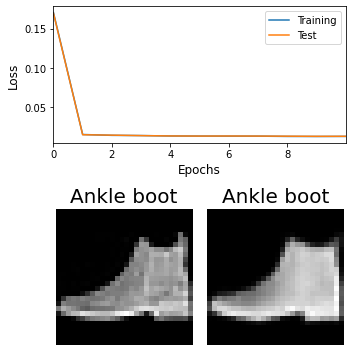

Epoch: __ 10
Train loss:  0.012354297
Test loss:  0.012507252
Model: "conv_autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_encoder (ConvEncoder)   (None, 10)                137226    
_________________________________________________________________
conv_decoder (ConvDecoder)   (None, 28, 28, 1)         143361    
Total params: 280,587
Trainable params: 280,587
Non-trainable params: 0
_________________________________________________________________
Wall time: 1min 45s


In [60]:
%%time
tf.keras.backend.clear_session()

learning_rate = 0.01
embedding_size = 10
epochs = 10

# Initialize the loss
loss_function = tf.keras.losses.MeanSquaredError()

# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize model
convAE = ConvAutoencoder(embedding_size)
convAE_performance = train_model(
    model = convAE,
    train_dataset = train_dataset,
    test_dataset = test_dataset,
    num_epochs = epochs,
    loss_function = loss_function,
    optimizer = optimizer
)
convAE.summary()

# Visualize results for each category

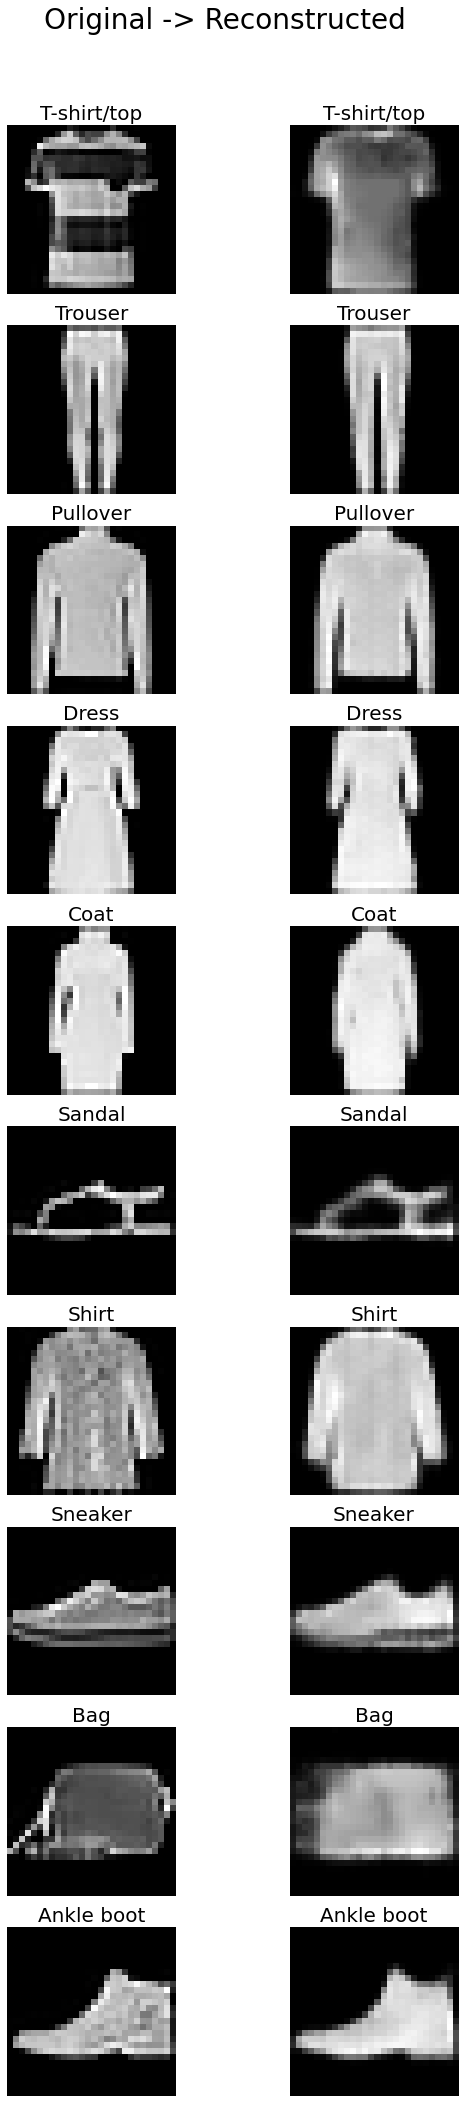

In [61]:
fig, ax = plt.subplots(10,2,figsize=(8,30))
fig.suptitle('Original -> Reconstructed', fontsize=28)
fig.tight_layout(rect=[0, 0, 1, 0.95])
for cat in range(10):
    idx = np.random.choice(np.where(test_labels==cat)[0])
    ax[cat,0].imshow(test_images[idx])
    ax[cat,0].set_title(explicit_labels[test_labels[idx]], fontsize=20)
    ax[cat,0].axis("off")

    ax[cat,1].imshow(convAE(np.expand_dims(test_images[idx]/255,(0,-1)).astype(np.float32)).numpy().squeeze())
    ax[cat,1].set_title(explicit_labels[test_labels[idx]], fontsize=20)
    ax[cat,1].axis("off")  

# Train variational Autoencoder

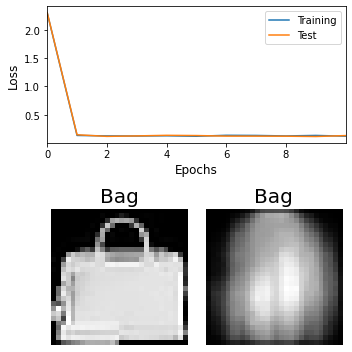

Epoch: __ 10
Train loss:  0.121676825
Test loss:  0.13215066
Model: "var_autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
var_encoder (VarEncoder)     (None, 10)                482241    
_________________________________________________________________
conv_decoder (ConvDecoder)   (None, 28, 28, 1)         143361    
Total params: 625,602
Trainable params: 625,602
Non-trainable params: 0
_________________________________________________________________
Wall time: 1min 34s


In [56]:
%%time
tf.keras.backend.clear_session()

learning_rate = 0.01
embedding_size = 10
epochs = 10


prior = tfp.distributions.Independent(tfp.distributions.Normal(loc=tf.zeros(embedding_size), scale=1),
                                      reinterpreted_batch_ndims=1)

# Initialize the loss
loss_function = tf.keras.losses.MeanSquaredError()

# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize model
varAE = VarAutoencoder(prior, embedding_size)
varAE_performance = train_model(
    model = varAE,
    train_dataset = train_dataset,
    test_dataset = test_dataset,
    num_epochs = epochs,
    loss_function = loss_function,
    optimizer = optimizer
)
varAE.summary()

# Visualize results for each category

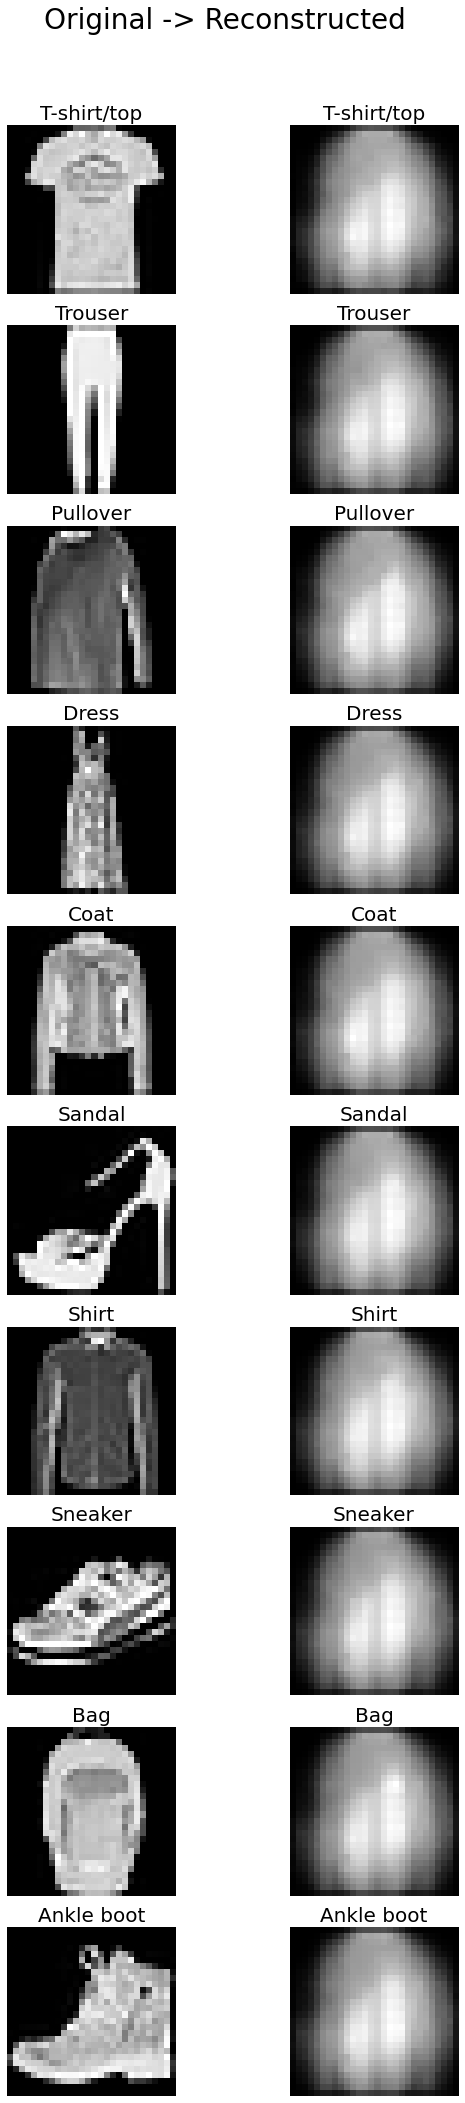

In [57]:
fig, ax = plt.subplots(10,2,figsize=(8,30))
fig.suptitle('Original -> Reconstructed', fontsize=28)
fig.tight_layout(rect=[0, 0, 1, 0.95])
for cat in range(10):
    idx = np.random.choice(np.where(test_labels==cat)[0])
    ax[cat,0].imshow(test_images[idx])
    ax[cat,0].set_title(explicit_labels[test_labels[idx]], fontsize=20)
    ax[cat,0].axis("off")

    ax[cat,1].imshow(varAE(np.expand_dims(test_images[idx]/255,(0,-1)).astype(np.float32)).numpy().squeeze())
    ax[cat,1].set_title(explicit_labels[test_labels[idx]], fontsize=20)
    ax[cat,1].axis("off")  

# Latent space analysis

In [101]:
t[0]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-1.1966355 , -0.2389909 , -1.2341691 ,  0.24446034,  0.592826  ,
        0.5399186 ,  0.6496599 , -0.5541771 ,  0.19830765,  0.8516796 ],
      dtype=float32)>

In [98]:
varAE.encoder(np.expand_dims(test_images[:1000]/255,(-1)).astype(np.float32)).mean().numpy().shape

(1000, 10)

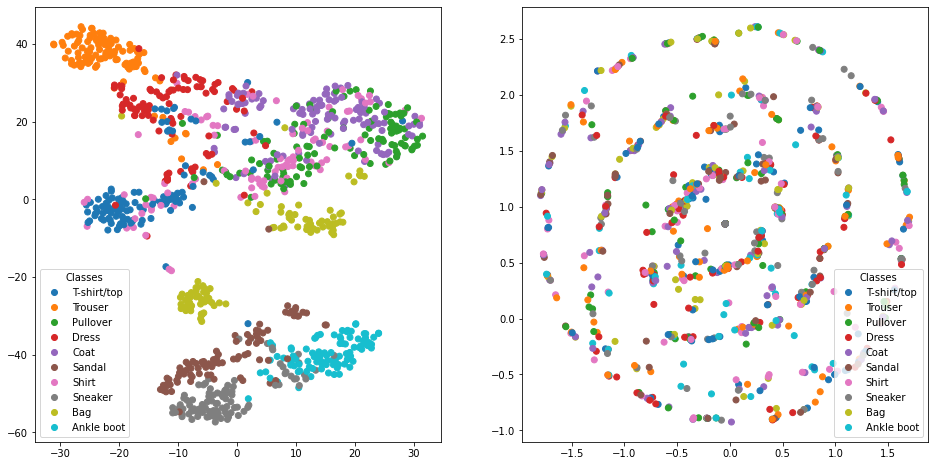

In [99]:
# Import t-SNE
from sklearn.manifold import TSNE

# Create embedding for first 1000 test images
embedded_images_simple = convAE.encoder(np.expand_dims(test_images[:1000]/255,(-1)).astype(np.float32)).numpy().squeeze()
embedded_images_variational = varAE.encoder(np.expand_dims(test_images[:1000]/255,(-1)).astype(np.float32)).mean().numpy()

tsne = TSNE(n_components=2)
autoencoder_tsne_simple = tsne.fit_transform(embedded_images_simple)
autoencoder_tsne_variational = tsne.fit_transform(embedded_images_variational)

fig = plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
scatter=plt.scatter(autoencoder_tsne_simple[:,0],
                   autoencoder_tsne_simple[:,1],
                   c=test_labels[:1000],
                   cmap='tab10'
                  )
# Of course having labels inside the scatter function working like color would be to easy for matplotlib...👌
plt.legend(handles=scatter.legend_elements()[0], title="Classes", labels=explicit_labels)
plt.subplot(1,2,2)
scatter=plt.scatter(autoencoder_tsne_variational[:,0],
                   autoencoder_tsne_variational[:,1],
                   c=test_labels[:1000],
                   cmap='tab10'
                  )

plt.legend(handles=scatter.legend_elements()[0], title="Classes", labels=explicit_labels)
plt.show()

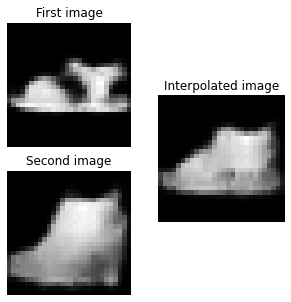

In [15]:
sample_embedded_simple = embedded_images_simple[np.random.randint(embedded_images_simple.shape[0], size=2)]
sample_embedded_simple = np.vstack((sample_embedded_simple,np.mean(sample_embedded_simple,0)))

interpolate_image_simple = convAE.decoder(sample_embedded_simple).numpy()

fig = plt.figure(figsize=(5,5))
plt.subplot(1,2,2)
plt.imshow(interpolate_image_simple[2])
plt.title('Interpolated image')
plt.axis("off")
plt.subplot(2,2,1)
plt.imshow(interpolate_image_simple[0])
plt.title('First image')
plt.axis("off")
plt.subplot(2,2,3)
plt.imshow(interpolate_image_simple[1])
plt.title('Second image')
plt.axis("off")

plt.show() 